<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [ ]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [ ]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

## **1.2** Parameters

In [5]:
# ------- Parameters -------
# Glove
emb_size = 200 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

## **1.3** General

In [ ]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [ ]:
import nltk
nltk.download('punkt', download_dir='/Users/mgalao/nltk_data')
nltk.data.path.append('/Users/mgalao/nltk_data')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/mgalao/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [ ]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

[==================================================] 100.0% 758.5/758.5MB downloaded


### Text Embeddings 3 Small

In [ ]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

In [ ]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [ ]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

### LSTM

In [ ]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

NameError: name 'units' is not defined

<div class="alert alert-block alert-success">

# **2.** **Hyperparameter Tuning**

<div>

## **2.1** LR with Text Embedding 3

### **2.1.1** Running Model

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
X_train_te3s, X_val_te3s, y_train_pred_te3s, y_val_pred_te3s = embedding_te3s(
    train_texts=train_texts,
    train_labels=train_labels,
    val_texts=val_texts,
    cache_file_train="X_train_te3s_embeddings.pkl",
    cache_file_val="X_val_te3s_embeddings.pkl",
    client=client,
    model_te3s=model_te3s,
    batch_size=32,
    model=model
)


In [ ]:
X_combined = np.vstack([X_train_te3s, X_val_te3s])
y_combined = np.concatenate([train_labels, val_labels])

split_index = [-1]*len(X_train_te3s) + [0]*len(X_val_te3s)
ps = PredefinedSplit(test_fold=split_index)

In [ ]:
param_grid = [
    {'penalty': ['l1'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']},

    {'penalty': ['l2'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']},

    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'l1_ratio': [0.0, 0.5, 1.0], 'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']}
]

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  # ou outro scoring adequado
    cv=ps,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_combined, y_combined)

In [ ]:
grid.best_params_
grid.best_score_
grid.best_estimator_

In [ ]:
print(grid.best_params_)

In [ ]:
print(grid.best_score_)

### **2.1.2** Assess

In [ ]:
model_lr = LogisticRegression( penalty='elasticnet',
    solver='saga',
    l1_ratio=0.4,
    C=10,
    class_weight=None,
    max_iter=1000,
    multi_class='ovr')

In [ ]:
title = "Logistic Regression with Text Embedding 3 Small"

In [ ]:
X_train_te3s,X_val_te3s,y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts,
                                                                 cache_file_train="X_train_te3s_embeddings.pkl",
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_lr)

In [ ]:
get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s)
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

## **2.2** XGB with Text Embedding 3

### **2.2.1** Run Model

In [ ]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [ ]:
param_grid_xgb = {
    'learning_rate': [0.2, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500],
    'subsample': [0.7,1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1],
}

In [ ]:
X_train_te3s, X_val_te3s, y_train_pred_te3s, y_val_pred_te3s = embedding_te3s(
    train_texts=train_texts,
    train_labels=train_labels,
    val_texts=val_texts,
    cache_file_train="X_train_te3s_embeddings.pkl",
    cache_file_val="X_val_te3s_embeddings.pkl",
    client=client,
    model_te3s=model_te3s,
    batch_size=32,
    model=xgb
)


In [ ]:
X_combined = np.vstack([X_train_te3s, X_val_te3s])
y_combined = np.concatenate([train_labels, val_labels])

split_index = [-1]*len(X_train_te3s) + [0]*len(X_val_te3s)
ps = PredefinedSplit(test_fold=split_index)

In [ ]:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=ps,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

In [ ]:
grid_xgb.fit(X_combined, y_combined)

### **2.2.2** Assess

In [ ]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

In [ ]:
xgb = XGBClassifier(
    colsample_bytree= 0.8,
    learning_rate = 0.2,
    max_depth = 4,
    n_estimators = 500, scale_pos_weight= 1, subsample = 0.7,
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [ ]:
title = "XGB with Text Embedding 3 Small"

In [ ]:
X_train_te3s,X_val_te3s,y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts,
                                                                 cache_file_train="X_train_te3s_embeddings.pkl",
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=xgb)

In [ ]:
get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s)
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

## **2.3** LSTM with Glove

### **2.3.1** Running model

In [ ]:
from sklearn.metrics import f1_score
import numpy as np


units_list = [64, 128]
dropout_list = [0.3, 0.4]
lr_list = [0.005, 0.001]

best_f1 = 0
best_params = {}

for units in units_list:
    for dropout in dropout_list:
        for lr in lr_list:
            print(f"\n Testing units={units}, dropout={dropout}, lr={lr}")

            input_ = Input(shape=(26, 200))
            x = Masking(mask_value=0.0)(input_)
            x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
            x = Dropout(dropout)(x)
            output = Dense(3, activation='softmax')(x)
            optimizer = Adam(learning_rate=lr)
            model_lstm = Model(inputs=input_, outputs=output)
            model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy',
                               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

            # Train and evaluate
            _, _, y_val_pred = embedding_glove_lstm(
                x_train=x_train,
                y_train=y_train,
                x_val=x_val,
                y_val=y_val,
                model_glove=glove_model,
                emb_size=200,
                model_lstm=model_lstm,
                n_classes=3,
                batch_size=32,
                epochs=15
            )

            f1 = f1_score(y_val, y_val_pred, average='macro')
            print(f" Val F1 Score: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

print("\nBest Params:", best_params)
print(f"Best Val F1: {best_f1:.4f}")


### **2.3.2** Assessing

In [ ]:
input_ = Input(shape=(26, 200))
x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=128, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)
optimizer=Adam(learning_rate=0.001)

In [ ]:
metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc', multi_label=True)]


In [ ]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics)

X_train_glove, y_train_pred_glove, y_val_pred_glove = embedding_glove_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, n_classes=3, batch_size=16, epochs=15, emb_size=emb_size, model_lstm=model_lstm)

In [ ]:
title = "LSTM Glove"

In [ ]:
get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove)

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

## **2.4** DistilBERT

In [6]:
# Tokenizer & Model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [8]:
# Tokenization function
def tokenize(example):
    return tokenizer(example["text"],truncation=True)

# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts_over, "label": train_labels_over}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map:   0%|          | 0/14826 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [14]:
# Model init with weighted loss
def model_init():
    config = AutoConfig.from_pretrained(checkpoint, num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3) # droupout
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config, ignore_mismatched_sizes=True)
    class_weights = torch.tensor(
        np.bincount(train_labels, minlength=3) / len(train_labels),
        dtype=torch.float
    )
    class_weights = 1.0 / class_weights
    model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    return model

In [15]:
# Search space
def hp_space(trial: Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 6),
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.15),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2)
    }

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Training args
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results/distilbert_tuning",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_dir="/content/drive/MyDrive/logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to=[]
)

In [17]:
# Trainer for tuning
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

<ipython-input-17-4025623868>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Hyperparameter tuning
best_trial = trainer.hyperparameter_search(
    direction="minimize", # Minimize loss
    n_trials=10,
    hp_space=hp_space,
    backend="optuna",
    compute_objective=lambda metrics: metrics["eval_loss"] # Use eval_loss as the objective metric
)

[I 2025-06-15 19:16:10,725] A new study created in memory with name: no-name-76b1a0a2-43ab-4d79-80d7-c9ea95846dda
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.252200,0.575635,0.826611,0.765799,0.824011,0.787613
2,0.088200,0.735469,0.855422,0.814535,0.813592,0.812318
3,0.028800,0.874109,0.847040,0.790791,0.826565,0.806687
4,0.030500,0.883531,0.852279,0.801982,0.823618,0.811975


[I 2025-06-15 19:22:18,877] Trial 0 finished with value: 0.8835307955741882 and parameters: {'learning_rate': 2.641968327373217e-05, 'num_train_epochs': 4, 'weight_decay': 0.06154816596866158, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.1138836807150751}. Best is trial 0 with value: 0.8835307955741882.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.308900,0.514463,0.819277,0.760630,0.817838,0.780791
2,0.123100,0.683799,0.844945,0.806923,0.794844,0.799206
3,0.060100,0.803590,0.842326,0.787124,0.820840,0.801634
4,0.051500,0.862370,0.840230,0.781902,0.823616,0.799796


[I 2025-06-15 19:28:32,387] Trial 1 finished with value: 0.8623696565628052 and parameters: {'learning_rate': 1.3129522489778903e-05, 'num_train_epochs': 4, 'weight_decay': 0.0819193911931012, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.12405782898201966}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.225600,0.701523,0.831325,0.767677,0.828291,0.792155
2,0.085800,0.903794,0.850183,0.798958,0.821891,0.808646
3,0.042600,1.006416,0.861184,0.834052,0.795267,0.812943
4,0.025500,1.138050,0.855422,0.818820,0.798514,0.807864
5,0.006100,1.153432,0.854374,0.806505,0.815185,0.810429


[I 2025-06-15 19:38:22,088] Trial 2 finished with value: 1.15343177318573 and parameters: {'learning_rate': 2.3390878151344577e-05, 'num_train_epochs': 5, 'weight_decay': 0.14171688526034745, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.018206961409630764}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.298200,0.539326,0.828182,0.783034,0.802789,0.785307
2,0.195800,0.774522,0.839707,0.786209,0.812072,0.797480
3,0.039600,1.024695,0.833421,0.773114,0.818665,0.792816
4,0.054500,1.083227,0.837087,0.779259,0.819348,0.796781
5,0.052400,1.106327,0.840230,0.785298,0.814130,0.798096


[I 2025-06-15 19:48:16,508] Trial 3 finished with value: 1.106326937675476 and parameters: {'learning_rate': 1.1469430804574605e-05, 'num_train_epochs': 5, 'weight_decay': 0.07641432813251092, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.13607818438111902}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.276300,0.553280,0.832373,0.783586,0.813267,0.791605
2,0.194500,0.780879,0.844945,0.792970,0.824812,0.804685
3,0.044300,1.013554,0.831849,0.770180,0.816677,0.790181
4,0.058500,1.122949,0.829230,0.767462,0.820985,0.789503
5,0.024700,1.091987,0.842326,0.786027,0.822628,0.801866


[I 2025-06-15 19:58:13,508] Trial 4 finished with value: 1.091986894607544 and parameters: {'learning_rate': 1.0701475776380205e-05, 'num_train_epochs': 5, 'weight_decay': 0.03067358926535889, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.09273549818586523}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.259000,0.571881,0.830801,0.775744,0.816973,0.791193


[I 2025-06-15 19:59:38,666] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.214800,0.627585,0.841278,0.784599,0.825056,0.801742
2,0.103500,0.872259,0.845993,0.792523,0.822993,0.804310
3,0.036500,0.958339,0.856993,0.814637,0.817103,0.814532
4,0.017700,0.988254,0.857517,0.806911,0.828978,0.816997


[I 2025-06-15 20:07:21,816] Trial 6 finished with value: 0.9882543087005615 and parameters: {'learning_rate': 1.726359182664016e-05, 'num_train_epochs': 4, 'weight_decay': 0.09182681321777283, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.04398732138293204}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.340600,0.533151,0.820325,0.773181,0.803500,0.779385
2,0.222300,0.780444,0.842326,0.787171,0.813789,0.799410
3,0.053400,1.007163,0.834992,0.773968,0.818269,0.793045
4,0.057300,1.072864,0.843373,0.788905,0.814277,0.800417
5,0.032500,1.154712,0.848612,0.805145,0.809490,0.805571
6,0.003800,1.198554,0.845993,0.797789,0.810870,0.803766


[I 2025-06-15 20:19:31,111] Trial 7 finished with value: 1.1985540390014648 and parameters: {'learning_rate': 1.4283500586531948e-05, 'num_train_epochs': 6, 'weight_decay': 0.0812762643137429, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.1770324487891655}. Best is trial 1 with value: 0.8623696565628052.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.256900,0.628271,0.823992,0.762629,0.817336,0.783538


[I 2025-06-15 20:20:57,537] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.278100,0.519032,0.827135,0.768433,0.821934,0.789592
2,0.084000,0.748708,0.832373,0.784279,0.814750,0.792703
3,0.043000,0.807051,0.844945,0.789839,0.828719,0.806324
4,0.017400,0.829673,0.852803,0.817435,0.798345,0.807141
5,0.005700,0.858550,0.855422,0.810023,0.828469,0.818494
6,0.002100,0.883913,0.860136,0.819943,0.822590,0.820641


[I 2025-06-15 20:29:37,897] Trial 9 finished with value: 0.8839128017425537 and parameters: {'learning_rate': 3.6979553272747034e-05, 'num_train_epochs': 6, 'weight_decay': 0.011623445782200044, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.042832231072252425}. Best is trial 1 with value: 0.8623696565628052.


In [19]:
# Retrain with best trial
best_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    save_strategy="no",
    learning_rate=float(best_trial.hyperparameters["learning_rate"]),
    per_device_train_batch_size=int(best_trial.hyperparameters["per_device_train_batch_size"]),
    num_train_epochs=int(best_trial.hyperparameters["num_train_epochs"]),
    weight_decay=float(best_trial.hyperparameters["weight_decay"]),
    warmup_ratio=float(best_trial.hyperparameters["warmup_ratio"]),
    logging_dir="./logs",
    report_to="none"
)

best_model = model_init()
best_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

best_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-3772277374>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(


Step,Training Loss
500,0.812800
1000,0.354000
1500,0.186600
2000,0.135800
2500,0.079200
3000,0.056800
3500,0.049700


TrainOutput(global_step=3708, training_loss=0.22868801835028227, metrics={'train_runtime': 329.1883, 'train_samples_per_second': 180.152, 'train_steps_per_second': 11.264, 'total_flos': 787281243725736.0, 'train_loss': 0.22868801835028227, 'epoch': 4.0})

In [20]:
# Get predictions for train and val sets
train_preds = best_trainer.predict(dataset["train"])
val_preds = best_trainer.predict(dataset["validation"])

train_labels = train_preds.label_ids
train_pred_labels = np.argmax(train_preds.predictions, axis=1)

val_labels = val_preds.label_ids
val_pred_labels = np.argmax(val_preds.predictions, axis=1)

In [21]:
title = "Best DistilBERT Model Performance (Optuna)"

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,Best DistilBERT Model Performance (Optuna),0.9933,0.8012,0.9933,0.7861,0.9933,0.8199,0.9933,0.8428


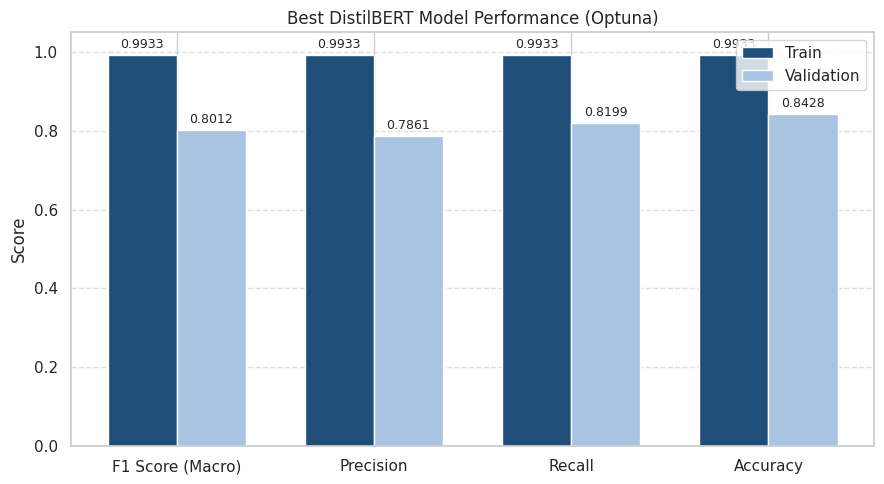

In [22]:
metrics_df = get_metrics_df(title, train_labels, train_pred_labels, val_labels, val_pred_labels)
display(metrics_df)

plot_metrics(train_labels, train_pred_labels, val_labels, val_pred_labels, title=title)

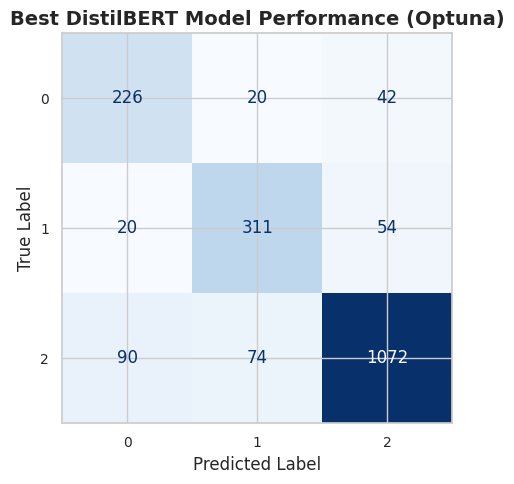

In [24]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, val_pred_labels, title=title, labels=[0, 1, 2], cmap="Blues")

In [23]:
output_path = "./best_distilbert_model"
best_model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

('./best_distilbert_model/tokenizer_config.json',
 './best_distilbert_model/special_tokens_map.json',
 './best_distilbert_model/vocab.txt',
 './best_distilbert_model/added_tokens.json',
 './best_distilbert_model/tokenizer.json')

## **2.5** RoBERTa

In [ ]:
# Tokenizer & Model
checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# droupout
config = AutoConfig.from_pretrained(checkpoint, num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(example):
    return tokenizer(example["text"],truncation=True)

In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts_over, "label": train_labels_over}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Model init with weighted loss
def model_init():
    config = AutoConfig.from_pretrained(checkpoint, num_labels=3, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

    class_weights = torch.tensor(
        np.bincount(train_labels, minlength=3) / len(train_labels),
        dtype=torch.float
    )
    class_weights = 1.0 / class_weights
    model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    return model

In [ ]:
# Search space
def hp_space(trial: Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 6),
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.15),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2)
    }

In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    save_strategy="no",
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to=[]
)

In [ ]:
# Trainer for tuning
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

<ipython-input-44-4025623868>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Hyperparameter tuning
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    n_trials=10,
    hp_space=hp_space,
    backend="optuna"
)

[I 2025-06-15 17:30:57,017] A new study created in memory with name: no-name-fc54e87e-724a-4fb9-a32c-d271788d18ef
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.998800
200,0.811800
300,0.729600
400,0.637000
500,0.590800
600,0.545800
700,0.534000
800,0.510300
900,0.507700
1000,0.473000


[I 2025-06-15 17:36:38,367] Trial 0 finished with value: 3.3329035736200585 and parameters: {'learning_rate': 1.1859235305497283e-05, 'num_train_epochs': 4, 'weight_decay': 0.088082168665227, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.05245453163698215}. Best is trial 0 with value: 3.3329035736200585.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.971900
200,0.741400
300,0.688600
400,0.579600
500,0.555800
600,0.523500
700,0.500100
800,0.488800
900,0.476500
1000,0.436500


[I 2025-06-15 17:45:05,267] Trial 1 finished with value: 3.3693988626459896 and parameters: {'learning_rate': 1.730130282846843e-05, 'num_train_epochs': 6, 'weight_decay': 0.04680972358213915, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.031117626302846913}. Best is trial 1 with value: 3.3693988626459896.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.043800
200,0.900800
300,0.757900
400,0.641300
500,0.580200
600,0.547200
700,0.514300
800,0.487200
900,0.498400
1000,0.443500


[I 2025-06-15 17:53:32,147] Trial 2 finished with value: 3.38081349438067 and parameters: {'learning_rate': 1.7799952978775266e-05, 'num_train_epochs': 6, 'weight_decay': 0.011179519642655107, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.14431440329775533}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.901100
200,0.675900
300,0.609600
400,0.529800
500,0.497500
600,0.474400
700,0.455800
800,0.418300
900,0.450800
1000,0.406100


[I 2025-06-15 18:01:02,195] Trial 3 finished with value: 3.345684056413807 and parameters: {'learning_rate': 1.3711327838391172e-05, 'num_train_epochs': 6, 'weight_decay': 0.11360263391832112, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.016420292678944206}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.067500
200,0.947900
300,0.878000
400,0.780400
500,0.742300
600,0.644100
700,0.627000
800,0.591800
900,0.671700
1000,0.570100


[I 2025-06-15 18:09:54,341] Trial 4 finished with value: 3.3638385842955048 and parameters: {'learning_rate': 2.3574000581995794e-05, 'num_train_epochs': 5, 'weight_decay': 0.14305982175057325, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.17494275131420167}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.863200
200,0.710700
300,0.639700
400,0.559700
500,0.535400
600,0.502900
700,0.483800
800,0.462400
900,0.453800
1000,0.422200


[I 2025-06-15 18:16:58,193] Trial 5 finished with value: 3.348181942017413 and parameters: {'learning_rate': 2.4153787577459382e-05, 'num_train_epochs': 5, 'weight_decay': 0.13629568059676708, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.0009120813310246279}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.027600
200,0.875900
300,0.754200
400,0.694300
500,0.636800
600,0.573400
700,0.586700
800,0.559000
900,0.618000
1000,0.524000


[I 2025-06-15 18:24:05,223] Trial 6 finished with value: 3.315092882552994 and parameters: {'learning_rate': 1.6107767138091986e-05, 'num_train_epochs': 4, 'weight_decay': 0.10846524693773998, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.0526594890854081}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,1.013300
200,0.842400
300,0.721100
400,0.575600
500,0.562100
600,0.518800
700,0.510600
800,0.488300
900,0.483700
1000,0.435100


[I 2025-06-15 18:29:46,104] Trial 7 finished with value: 3.3697332126868553 and parameters: {'learning_rate': 2.6022970395785854e-05, 'num_train_epochs': 4, 'weight_decay': 0.013780443971437899, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.15727849013971057}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.976500
200,0.719600
300,0.615900
400,0.517500
500,0.478700
600,0.418400
700,0.413100
800,0.367100
900,0.381000
1000,0.344400


[I 2025-06-15 18:37:16,274] Trial 8 finished with value: 3.3504130456181604 and parameters: {'learning_rate': 2.949214205025734e-05, 'num_train_epochs': 6, 'weight_decay': 0.08802091730645538, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.1628114293458044}. Best is trial 2 with value: 3.38081349438067.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.954400
200,0.698700
300,0.593800
400,0.500100
500,0.465900
600,0.433600
700,0.417600
800,0.376000
900,0.395900


[I 2025-06-15 18:42:18,893] Trial 9 finished with value: 3.3239719156631264 and parameters: {'learning_rate': 2.7206262745452945e-05, 'num_train_epochs': 4, 'weight_decay': 0.09533419087035688, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.16434446869048613}. Best is trial 2 with value: 3.38081349438067.


In [ ]:
# Retrain with best trial
best_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",
    save_strategy="no",
    learning_rate=float(best_trial.hyperparameters["learning_rate"]),
    per_device_train_batch_size=int(best_trial.hyperparameters["per_device_train_batch_size"]),
    num_train_epochs=int(best_trial.hyperparameters["num_train_epochs"]),
    weight_decay=float(best_trial.hyperparameters["weight_decay"]),
    warmup_ratio=float(best_trial.hyperparameters["warmup_ratio"]),
    logging_dir="./logs",
    report_to="none"
)

best_model = model_init()
best_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_transformers
)

best_trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-46-2593341178>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(


Step,Training Loss
500,0.781600
1000,0.508900
1500,0.422300
2000,0.371600
2500,0.345200


TrainOutput(global_step=2868, training_loss=0.4642030777126509, metrics={'train_runtime': 498.9618, 'train_samples_per_second': 91.799, 'train_steps_per_second': 5.748, 'total_flos': 1210919893459416.0, 'train_loss': 0.4642030777126509, 'epoch': 6.0})

In [ ]:
# Get predictions for train and val sets
train_preds = best_trainer.predict(dataset["train"])
val_preds = best_trainer.predict(dataset["validation"])

train_labels = train_preds.label_ids
train_pred_labels = np.argmax(train_preds.predictions, axis=1)

val_labels = val_preds.label_ids
val_pred_labels = np.argmax(val_preds.predictions, axis=1)

In [ ]:
title = "Best RoBERTa Model Performance (Optuna)"

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,Best RoBERTa Model Performance (Optuna),0.8832,0.835,0.8606,0.8163,0.912,0.8582,0.9048,0.8669


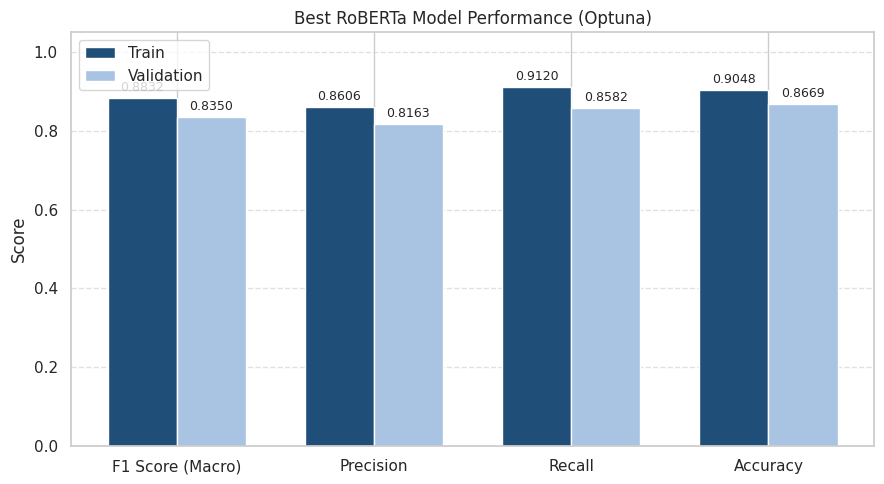

In [ ]:
metrics_df = get_metrics_df(title, train_labels, train_pred_labels, val_labels, val_pred_labels)
display(metrics_df)

plot_metrics(train_labels, train_pred_labels, val_labels, val_pred_labels, title=title)

In [ ]:
output_path = "./best_roberta_model_2"
best_model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

('./best_roberta_model_2/tokenizer_config.json',
 './best_roberta_model_2/special_tokens_map.json',
 './best_roberta_model_2/vocab.json',
 './best_roberta_model_2/merges.txt',
 './best_roberta_model_2/added_tokens.json',
 './best_roberta_model_2/tokenizer.json')